# Imports

In [1]:
import ipywidgets as widgets
from IPython.display import clear_output, display, Image
import os
import pickle
import gc

import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont

from scipy.spatial.transform import Rotation as R
from tqdm.notebook import tqdm

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

import torchvision.transforms as T
from torchvision.ops import box_convert
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes

In [3]:
HOME = os.getcwd()
print(HOME)

/home/kumaraditya_gupta/instance-map


In [4]:
#RAM Imports
from ram.models import ram
from ram import inference_ram as inference

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import load_model, load_image, predict, annotate

import supervision as sv

# Segment Anything
from segment_anything import build_sam, SamPredictor

#Embeddings
import open_clip

# Setup

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
weights_dir = "/scratch/kumaraditya_gupta/checkpoints"
dataset_dir = "/scratch/kumaraditya_gupta/Datasets/mp3d_test/RPmz2sHmrrY/sequence4"
stride = 1

output_dir = os.path.join(dataset_dir, "output_objs_v1")
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

imgs_dir = os.path.join(dataset_dir, "color")
depth_dir = os.path.join(dataset_dir, "depth")
pose_dir =  os.path.join(dataset_dir, "pose")

In [7]:
img_files = [f for f in os.listdir(imgs_dir) if os.path.isfile(os.path.join(imgs_dir, f))]
img_files = sorted(img_files, key=lambda x: int(x.split('.')[0]))
img_files = img_files[::stride]
img_dict = {}

In [8]:
# img_files = img_files[:300]
print(len(img_files))

821


# RAM Load + Run

In [9]:
image_size = 384 # default value
pretrained = f"{weights_dir}/ram_swin_large_14m.pth"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(), normalize
])

#Load model
ram_model = ram(pretrained=pretrained,
                          image_size=image_size,
                          vit='swin_l')
ram_model.eval()

ram_model = ram_model.to(device)

/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
/scratch/kumaraditya_gupta/checkpoints/ram_swin_large_14m.pth
--------------
load checkpoint from /scratch/kumaraditya_gupta/checkpoints/ram_swin_large_14m.pth
vit: swin_l


In [10]:
# # Loop through each image file

add_classes = ["other item"]
remove_classes = [
    "room", "kitchen", "office", "house", "home", "building", "corner",
    "shadow", "carpet", "photo", "shade", "stall", "space", "aquarium", 
    "apartment", "image", "city", "blue", "skylight", "hallway", 
    "bureau", "modern", "salon", "doorway", "wall lamp", "pillar",
    "door", "basement", "workshop", "warehouse"
]
bg_classes = ["wall", "floor", "ceiling", "office"]

for i, img_file in enumerate(tqdm(img_files)):
    img_id = os.path.splitext(img_file)[0]
    img_path = os.path.join(imgs_dir, img_file)
    raw_image = Image.open(img_path).convert("RGB").resize((image_size, image_size))
    image = transform(raw_image).unsqueeze(0).to(device)

    ram_tags = inference(image, ram_model)[0]
    ram_tags = ram_tags.split(' | ') # Split the tags

    ram_tags = [tag for tag in ram_tags if tag not in bg_classes]
    for tag in ram_tags:
        words = tag.split()
        for word in words:
            if word in remove_classes:
                ram_tags.remove(tag)
                break
    ram_tags.extend(add_classes)

    # ram_tags = [tag.split() for tag in ram_tags] # Split the tags into words
    # ram_tags = [item for sublist in ram_tags for item in sublist] # Flatten the list
    # ram_tags = list(set(ram_tags) & set(req_tags)) # Get the intersection of the tags

    ram_tags = " , ".join(str(tag) for tag in ram_tags) # Join the tags with a period
    # print(ram_tags)

    # Add the img_path and ram_tags to the dictionary
    img_dict[img_id] = {'img_path': img_path, 'ram_tags': ram_tags, 'objs': {}}

  0%|          | 0/821 [00:00<?, ?it/s]

In [13]:
print(img_dict['056']['ram_tags'])

lamp , cabinet , closet , decorate , doll , figurine , hut , picture frame , showcase , stocking , toy , other item


In [157]:
# # background_prompt = "Identify elements like any doors, doorframes, walls, and transition areas between rooms"
# background_prompt = "wall , door , doorframe , partition"

# for i, img_file in enumerate(tqdm(img_files)):
#     img_id = os.path.splitext(img_file)[0]
#     img_path = os.path.join(imgs_dir, img_file)

#     # Add the img_path and ram_tags to the dictionary
#     img_dict[img_id] = {'img_path': img_path, 'ram_tags': background_prompt, 'objs': {}}

  0%|          | 0/262 [00:00<?, ?it/s]

In [14]:
del ram_model
torch.cuda.empty_cache()
gc.collect()

577

# GDINO + SAM Load and Run

In [15]:
CONFIG_PATH = f"{HOME}/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_NAME_GD = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH_GD = f"{weights_dir}/{WEIGHTS_NAME_GD}"
print(WEIGHTS_PATH_GD, "; exist:", os.path.isfile(WEIGHTS_PATH_GD))

/home/kumaraditya_gupta/instance-map/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/scratch/kumaraditya_gupta/checkpoints/groundingdino_swint_ogc.pth ; exist: True


In [16]:
#Load Model Grounding DINO
GDINO_model = load_model(CONFIG_PATH, WEIGHTS_PATH_GD)

final text_encoder_type: bert-base-uncased


In [17]:
sam_checkpoint_name = "sam_vit_h_4b8939.pth"
sam_checkpoint = f"{weights_dir}/{sam_checkpoint_name}"
sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

In [18]:
# SAM Functions
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()

In [19]:
BOX_TRESHOLD = 0.33
TEXT_TRESHOLD = 0.33

for img_id, img_data in tqdm(img_dict.items()):
    img_path = img_data['img_path']

    TEXT_PROMPT = img_dict[img_id]['ram_tags']
    image_source, image = load_image(img_path)

    # Get DINO Bounding Boxes
    boxes, logits, phrases = predict(
        model=GDINO_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    # print(boxes)

    if boxes.nelement() == 0:
        continue

    # Get SAM Masks
    sam_image = cv2.imread(img_path)

    #NOTE: Only for iPad
    # sam_image = cv2.resize(sam_image, (int(sam_image.shape[1]/3.75), int(sam_image.shape[0]/3.75)))
    
    sam_image = cv2.cvtColor(sam_image, cv2.COLOR_BGR2RGB)
    segmented_frame_masks = segment(sam_image, sam_predictor, boxes=boxes)

    num_objs = boxes.shape[0]
    objs = {}

    for j in range(num_objs):
      img_data['objs'][j] = {'bbox': boxes[j].cpu().numpy(),
                             'phrase' : phrases[j],
                             'prob' : logits[j].item(),
                             'mask' : segmented_frame_masks[j].cpu().squeeze().numpy(),
                             'clip_embed' : None,
                             'dino_embed' : None}

  0%|          | 0/821 [00:00<?, ?it/s]

In [17]:
del sam_predictor
del GDINO_model
torch.cuda.empty_cache()
gc.collect()

28

# Clip + DINOv2 Embeddings

In [165]:
# img_dict_path = os.path.join(dataset_dir, "output_v1.2/kinect_g2o_img_dict.pkl")
# with open(img_dict_path, 'rb') as f:
#     img_dict = pickle.load(f)

In [18]:
def crop_image(image, bounding_box):
    height, width = image.shape[:2]

    x, y, w, h = bounding_box
    xmin = int((x - w/2).item() * width)
    ymin = int((y - h/2).item() * height)
    xmax = int((x + w/2).item() * width)
    ymax = int((y + h/2).item() * height)
    cropped_image = image[ymin:ymax, xmin:xmax]

    return cropped_image

def resize_and_pad(image, desired_size=256):
    old_size = image.shape[:2]  # old_size is in (height, width) format

    # find the larger dimension of the image
    max_dim = max(old_size)
    ratio = float(desired_size) / max_dim
    new_size = tuple([int(x*ratio) for x in old_size])
    image = cv2.resize(image, (new_size[1], new_size[0]))

    # compute the deltas for padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # create a border around the image
    color = [0, 0, 0]  # black padding
    new_img = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_img

In [19]:
# CLIP Model Loading and Preprocessing
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
        "ViT-H-14", "laion2b_s32b_b79k"
    )
clip_model = clip_model.to(device)

# Load the pre-trained DINO model
dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
dino_model = dino_model.to(device)
dino_model.eval()

# Define the image transformation pipeline
transform_dino = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Using cache found in /home/kumaraditya_gupta/.cache/torch/hub/facebookresearch_dinov2_main


In [20]:
# Combined Function for Calculating Embeddings

def get_dino_clip_embeddings(cropped_img):
    # Load and preprocess the image for DinoV2
    dino_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    dino_image_tensor = transform_dino(dino_img).unsqueeze(0).to(device)  # Add batch dimension and send to device

    # Get the feature embedding from the model
    with torch.no_grad():
        dino_features = dino_model(dino_image_tensor)[0]

    # Load and preprocess the image for CLIP
    image_clip = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    input_clip = clip_preprocess(image_clip).unsqueeze(0).to(device)

    # Calculate CLIP embeddings
    with torch.no_grad():
        clip_features = clip_model.encode_image(input_clip)

    clip_features /= clip_features.norm(dim=-1, keepdim=True)

    return dino_features, clip_features

In [21]:
for img_id, img_data in tqdm(img_dict.items()):
  img_path = img_data['img_path']
  img = cv2.imread(img_path)

  # NOTE: Only for iPad
  # img = cv2.resize(img, (int(img.shape[1]/3.75), int(img.shape[0]/3.75)))

  if len(img_data['objs']) == 0:
    continue

  for obj_id, obj_data in img_data['objs'].items():
    mask = obj_data['mask']

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Apply the mask to the image. This assumes your mask is binary (0s and 1s).
    # masked_image = img * np.expand_dims(mask, axis=2)
    cropped_img = crop_image(img, obj_data['bbox'])

    dino_features, clip_features = get_dino_clip_embeddings(cropped_img)

    clip_features = clip_features.cpu().squeeze().numpy()
    dino_features = dino_features.cpu().squeeze().numpy()

    obj_data['clip_embed'] = clip_features
    obj_data['dino_embed'] = dino_features
    # print("DinoV2 features shape:", dino_features.shape)
    # print("CLIP features shape:", clip_features.shape)

  0%|          | 0/821 [00:00<?, ?it/s]

In [22]:
del clip_model
del clip_preprocess
del dino_model
torch.cuda.empty_cache()
gc.collect()

28

# Save/Load img_dict

In [23]:
pickle_file_path = os.path.join(output_dir, "img_dict.pkl")

with open(pickle_file_path, 'wb') as file:
    pickle.dump(img_dict, file)

In [172]:
del img_dict
gc.collect()

0

In [7]:
# # Load from pickle file
# pickle_file_path = os.path.join(output_dir, "img_dict.pkl")
# with open(pickle_file_path, 'rb') as file:
#     img_dict = pickle.load(file)


# Experiments

office
Similarity with background embeds: 0.96240234375
Similarity with floor embeds: 0.894775390625
Similarity with ceiling embeds: 0.8486328125


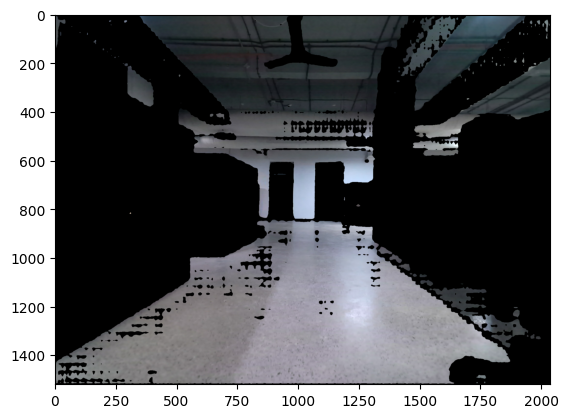

In [61]:
# def get_text_clip_embedding(text):
#     text_inputs = clip.tokenize([text]).to(device)
    
#     # Get the text features
#     with torch.no_grad():
#         text_features = model_clip.encode_text(text_inputs)
        
#     # Normalize the features
#     text_features /= text_features.norm(dim=-1, keepdim=True)
    
#     return text_features.cpu().squeeze().numpy()

def custom_cosine_similarity(vec1, vec2):
    # Ensure the vectors have the same shape
    if vec1.shape != vec2.shape:
        raise ValueError("Vectors must have the same shape.")

    # Compute the dot product of the vectors
    dot_product = np.dot(vec1, vec2)

    # Compute the magnitudes (Euclidean norms) of the vectors
    magnitude_vec1 = np.linalg.norm(vec1)
    magnitude_vec2 = np.linalg.norm(vec2)

    # Compute the cosine similarity
    similarity = dot_product / (magnitude_vec1 * magnitude_vec2)

    # Normalize the similarity value to [0, 1]
    normalized_similarity = 0.5 * (similarity + 1)

    return normalized_similarity

embedding_type = "clip_embed"

# chair_embed = get_text_clip_embedding("A photo of a dog")
# chair_embed = chair_embed.reshape(-1)
background_embed = img_dict['1']['objs'][2][embedding_type]
floor_embed = img_dict['1']['objs'][4][embedding_type]
ceiling_embed = img_dict['1']['objs'][9][embedding_type]

obj_id = 1
img_id = '504'

img = cv2.imread(img_dict[img_id]['img_path'])
mask = img_dict[img_id]['objs'][obj_id]['mask']
masked_image = img * np.expand_dims(mask, axis=2)
cropped_img = crop_image(masked_image, img_dict[img_id]['objs'][obj_id]['bbox'])

img_chair_embed = img_dict[img_id]['objs'][obj_id][embedding_type]

# show the image after converting from BGR to RGB color space
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))

print(img_dict[img_id]['objs'][obj_id]['phrase'])
print("Similarity with background embeds:", custom_cosine_similarity(img_chair_embed, background_embed))
print("Similarity with floor embeds:", custom_cosine_similarity(img_chair_embed, floor_embed))
print("Similarity with ceiling embeds:", custom_cosine_similarity(img_chair_embed, ceiling_embed))

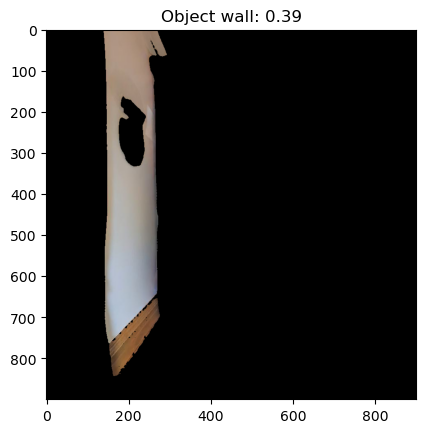

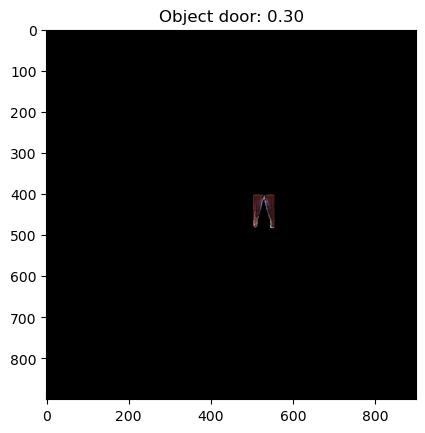

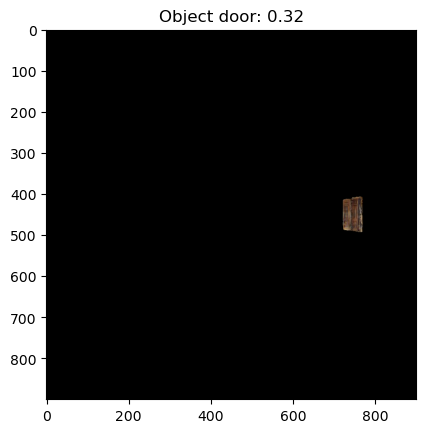

In [12]:
#Code to visualize separate masks for a single image

img_id = '0001'

# Load the image
img_path = img_dict[img_id]['img_path']
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Get the object data for the image
objs = img_dict[img_id]['objs']

# Loop through each object in the image
for obj_index, obj_data in objs.items():
    # Get the mask for the object
    mask = obj_data['mask']
    prob = obj_data['prob']
    obj_name = obj_data['phrase']

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Apply the mask to the image. This assumes your mask is binary (0s and 1s).
    # If it isn't, you may need to adjust this step accordingly.
    masked_image = img * np.expand_dims(mask, axis=2)

    # Display the masked image
    plt.figure()
    plt.imshow(masked_image)
    plt.title(f"Object {obj_name}: {prob:.2f}")
    plt.show()


In [28]:
def generate_pastel_color():
    return (
        int(random.uniform(0.5, 1.0) * 255), 
        int(random.uniform(0.5, 1.0) * 255), 
        int(random.uniform(0.5, 1.0) * 255)
    )

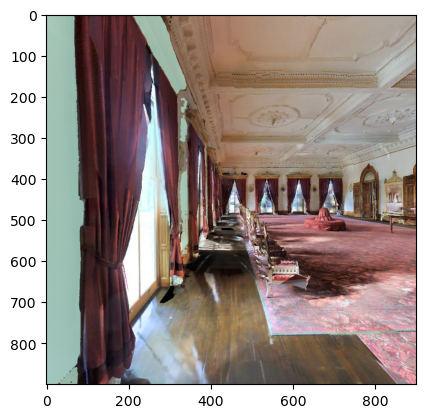

In [11]:
#Code to draw the segmentation mask on the image

from torchvision.utils import draw_segmentation_masks

def generate_pastel_color():
    return (
        int(random.uniform(0.5, 1.0) * 255), 
        int(random.uniform(0.5, 1.0) * 255), 
        int(random.uniform(0.5, 1.0) * 255)
    )

# Load the image
img_id = '0004'
img_path = img_dict[img_id]['img_path']
img = Image.open(img_path)  # Load with PIL to avoid needing to convert color spaces

transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img)
img_tensor = (img_tensor * 255).byte()

masks = []
mask_colors = []

objs = img_dict[img_id]['objs']

for obj_index, obj_data in objs.items():
    mask = obj_data['mask']

    phrase = obj_data['phrase']
    phrase = phrase.split()[0] #Use only the first phrase

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Add the mask to the list of masks
    masks.append(mask)
    #Cheeck the color for the mask and add it to the list
    color = generate_pastel_color()
    mask_colors.append(color)

# Convert the masks to a boolean tensor
masks_tensor = torch.tensor(masks, dtype=torch.bool)

# Draw all masks on the image
result = draw_segmentation_masks(img_tensor, masks_tensor, colors=mask_colors)

# Convert the result tensor back to a PIL image, transpose the dimensions back to H,W,C for PIL
result_img = Image.fromarray(result.permute(1, 2, 0).byte().cpu().numpy())

# Display the image with all masks
plt.imshow(result_img)
plt.show()


In [21]:
from torchvision.utils import draw_segmentation_masks

def generate_pastel_color():
    return (
        int(random.uniform(0.5, 1.0) * 255), 
        int(random.uniform(0.5, 1.0) * 255), 
        int(random.uniform(0.5, 1.0) * 255)
    )

def process_and_save_images(img_dict, save_folder):
    for img_id, img_data in tqdm(img_dict.items()):
        img_path = img_data['img_path']
        sam_image = cv2.imread(img_path)
        sam_image_rgb = cv2.cvtColor(sam_image, cv2.COLOR_BGR2RGB)
        tensor_image = torch.from_numpy(sam_image_rgb).permute(2, 0, 1)

        objs = img_data['objs']
        sorted_objs = sorted(objs.items(), key=lambda x: np.sum(x[1]['mask']), reverse=True)

        # Draw segmentation masks
        for _, obj in sorted_objs:
            mask = obj['mask']
            tensor_mask = torch.from_numpy(mask).to(torch.bool)
            tensor_image = draw_segmentation_masks(tensor_image, tensor_mask, colors=generate_pastel_color(), alpha=0.7)

        # Convert tensor back to image for drawing bounding boxes
        final_image = tensor_image.permute(1, 2, 0).numpy()
        final_image = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)

        # Draw bounding boxes and text
        for _, obj in sorted_objs:
            bbox = obj['bbox']
            phrase = obj['phrase']
            prob = obj['prob']

            if phrase == "room" or phrase == "rooms":
                continue

            # Draw bounding box
            start_point = (int(bbox[0]), int(bbox[1]))
            end_point = (int(bbox[2]), int(bbox[3]))
            final_image = cv2.rectangle(final_image, start_point, end_point, (0, 255, 0), 2)

            # Overlay text
            text = f"{phrase}, {prob:.2f}"
            final_image = cv2.putText(final_image, text, (start_point[0], start_point[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Save the image
        save_path = os.path.join(save_folder, f"{img_id}_processed.jpg")
        cv2.imwrite(save_path, final_image)

# Usage
save_folder = '/scratch/kumaraditya_gupta/Datasets/mp3d_1/gsam_output_v1.1'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
process_and_save_images(img_dict, save_folder)


  0%|          | 0/843 [00:00<?, ?it/s]